# RKDE (Robust Kernel Density Estimation)

## Generating  the data set

In [9]:
import numpy as np 
import matplotlib.pyplot as plt

# Define the number of points
n_samples = 250

mu1, sigma1 = 0,1 # mean and variance
mu2, sigma2 = 10,1

x1 = np.random.normal(mu1,np.sqrt(sigma1),n_samples)
x2 = np.random.normal(mu2,np.sqrt(sigma2),n_samples)

def pdf(loc,variance,observation):
    '''Giving the Probability Density Function

    Parameters
    ----------
        loc (Int): Mean of the distribution ; where the peak of the bell exists
        variance(Int) : variance
        sample (Array) : the distribution

    Returns
    -------
        ndrray: Gaussian distribution
    '''
    # A normal continuous random variable.
    s1 = 1/(np.sqrt(2*np.pi*variance))
    s2 = np.exp(-(np.square(observation - loc)/(2*variance)))
    return s1 * s2 

# Adding outliers
outliers = np.random.randint(-5,15,40)
""" x1 = np.append(x1,outliers[:21])
x2 = np.append(x2,outliers[21:])
 """
X = np.array(list(x1) + list(x2))
X = np.append(X, outliers)
np.random.shuffle(X)
print("Dataset Shape: ", X.shape)
n_samples_final = X.shape[0]

Dataset Shape:  (540,)


### Visualize the training data

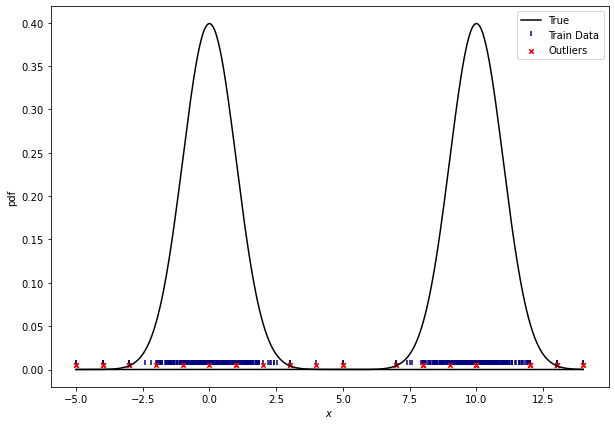

In [10]:
bins = np.linspace(np.min(X),np.max(X),n_samples_final)

plt.figure(figsize=(10,7))
plt.xlabel("$x$")
plt.ylabel("pdf")

plt.scatter(X,[.005] * len(X), color='navy', s=30, marker=2, label="Train Data")
plt.scatter(outliers,[.005] * len(outliers), color='red', s=20, marker='x', label="Outliers")


plt.plot(bins, pdf(mu1,sigma1,bins), color='black', label="True")
plt.plot(bins, pdf(mu2,sigma2,bins), color='black')

plt.legend()
plt.show()

## Applying KDE (Kernel Density Estimation)

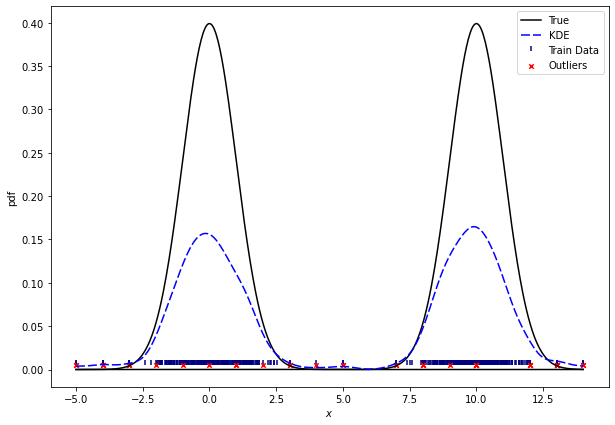

In [11]:
def kernel_function(obs,givenData,h,d=1):
    """ Kernel Function

    Parameters
    ----------
        obs (Int): Observation data
        h (Int): variance of the distribution
        d (Int, optional): dimension
        givenData (Int): Gaussian value
    
    Returns
    -------
        Int: kernel value   
    """
    result = (h**2 * 2*np.pi)**(-d/2) *np.exp((-1/2)* ((obs - givenData)/h)**2)
    return result

def kernel_density_function(obs_data,givenData,h=.1,d=1):
    '''Kernel Density Function
    Parameters
    ----------
        obs_data (Array): Observation data  
        h (Int): windows size
        d (Int, optional): dimension
        givenData (Array): Gaussian values

    Returns
    -------
      Array: new data after applying kdf
    '''
    final_result = []
    # Size of the gaussian data
    size = len(givenData)
    for obs in obs_data:
        k_result = 0
        for g in givenData:
            k_result +=  (1/size) * kernel_function(obs,g,h)
        final_result.append(k_result)
    return final_result

""" variance = np.var(X)
print(variance) """
windows = (1/np.sqrt(n_samples_final)*10)
X_kde = kernel_density_function(bins,X,windows)
#X_kde2 = kernel_density_function(bins,(x2))

##### PLOTING ##########
plt.figure(figsize=(10,7))
plt.xlabel("$x$")
plt.ylabel("pdf")

plt.scatter(X,[.005] * len(X), color='navy', s=30, marker=2, label="Train Data")
plt.scatter(outliers,[.005] * len(outliers), color='red', s=20, marker='x', label="Outliers")

plt.plot(bins, pdf(mu1,sigma1,bins), color='black', label="True")
plt.plot(bins, pdf(mu2,sigma2,bins), color='black')

plt.plot(bins, X_kde, color='blue', label="KDE", dashes=[6,2])
#plt.plot(bins, X_kde2, color='blue', dashes=[6,2])

plt.legend()
plt.show()

## Applying RKDE (Robust Kernel Density Estimation)

#### Step1 : Initialize wi(0) . Let k = 1.

In [12]:
def generate_weights(_sum,n):
    '''Generate n integers that sum up to a fixed number. 
    Ideally, the n numbers should be close to the mean of these numbers within a ~25% deviation.

    Parameters
    ----------
        _sum (int): the fixed sum of the weights  
        n (Int): number of weight

    Returns
    -------
      Array: the weights
    '''
    mean = _sum / n
    variance = float(.25 * mean)

    min_v = mean - variance
    max_v = mean + variance

    array = [min_v] * n

    diff = _sum - min_v * n
    while diff > 0 :
        a = np.random.randint(0,n-1)
        if array[a] >= max_v:
            continue
        array[a] += 1
        diff -= 1
    return array

w_0 = generate_weights(100,n_samples_final)
#numbers = np.random.multinomial(100,np.ones(240)/240, size=1)[0]

## Step 2

In [34]:
# k is the number of iteration
k = 1

operand_1 = kernel_function(X[k-1],X[k-1],windows)
print(operand_1)

def operand_2_func(weights,X,size_dist,windows):
    '''Generate operand 2

    Parameters
    ----------
        weights (array): the weights  
        X (array): the distribution
        windows (int): Windows size

    Returns
    -------
      int: operand 2
    '''
    result = []
    for j in range(size_dist):
       result.append(-2*weights[j]*kernel_function(X[k-1],X[j],windows))
       #print(result)
    return result
operand_2 = operand_2_func(w_0,X,n_samples_final,windows)
#print(operand_2)
def operand_3_func(weights,X, size_dist,windows):

  '''Generate operand 3

    Parameters
    ----------
        weights (array): the weights  
        X (array): the distribution
        windows (int): Windows size
    Returns
    -------
      int: operand 3
    '''
  final_result = []
  for i in range(size_dist):
    result = 0
    for j in range(size_dist):
      result += weights[i]*weights[j]*kernel_function(X[i],X[j],windows)
    final_result.append(result)
  return final_result
operand_3 = operand_3_func(w_0,X,n_samples_final,windows)
#print(operand_3)
step2_result = np.sqrt(operand_1 + operand_2 + operand_3)


0.927058084855655


## Step 3

In [ ]:
def huber_loss_func(value):
    alpha = 1
    if value < -alpha:
        return -alpha
    elif -alpha <= value and value <= alpha:
        return value
    else:
        return alpha

def update_weights(step2_result):
    updated_weights =[]
    for value in step2_result:
        updated_weights.append(huber_loss_func(value) / value)
    return updated_weights

updated_weights = update_weights(step2_result)
print(update_weights)
